# Predictive Maintenance for NASA Industrial Machinery

## Objective
The objective for this project is to train and build a machine learning model to predict machine equipment failures or maintenance needs based on sensor data and historical maintenance records, and deploy it as an interactive web application using the DASH framework. The web side of the application will be deployed on render.com

## Case Study Context
We as a group decided to cater the Predictive Maintenance topic towards a specific case scenario. This model will specifically be used to predict maintenance in the aerospace field. We will ustilise the NASA Turbofan Jet Engine Dataset found on kaggle to predict the remaining life span of equipment, or more commonly known as the remaining useful like (RUL). We will also work on predicting whether maintenance is needed and when maintenance will be required. 

## Dataset Description
The dataset simulates jet engine degradation under various operating conditions. It includes four subsets (FD001–FD004), each with different fault modes and operating conditions. It can be found on kaggle: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps. The NASA Turbofan Jet Engine Dataset contains 4 subsets of data. This includes FD001 - FD004. Each subset has a RUL datafile, a test datafile, and a train datafile. For this specific project FD001 will be utilised due to it being the simplest subset, its single fault mode, and its constant operating conditions. This will assist with manageability. At a later stage we will look into training subset FD002-FD004.

## Libraries Used

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
import time
warnings.filterwarnings('ignore')

## Loading the Data (FD001)
Currently the data is in a single columnar textfile. We need to break it down into a tabular format. The data is separated into the column headings 'unit', 'cycle','setting1','setting2','setting3', and then 'sensor(i)' with i being 1 to and including 21. 

In [33]:
columns = ['unit', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
df1 = pd.read_csv(
    '../dataset/train_FD001.txt', sep='\\s+', header=None, names=columns)
df2 = pd.read_csv(
    '../dataset/train_FD002.txt', sep='\\s+', header=None, names=columns)
df3 = pd.read_csv(
    '../dataset/train_FD003.txt', sep='\\s+', header=None, names=columns)
df4 = pd.read_csv(
    '../dataset/train_FD004.txt', sep='\\s+', header=None, names=columns)

df2['unit'] += df1['unit'].max()
df3['unit'] += df2['unit'].max()
df4['unit'] += df3['unit'].max()

df = pd.concat([df1, df2, df3, df4])

t1 = pd.read_csv(
    '../dataset/test_FD001.txt', sep='\\s+', header=None, names=columns)
t2 = pd.read_csv(
    '../dataset/test_FD002.txt', sep='\\s+', header=None, names=columns)
t3 = pd.read_csv(
    '../dataset/test_FD003.txt', sep='\\s+', header=None, names=columns)
t4 = pd.read_csv(
    '../dataset/test_FD004.txt', sep='\\s+', header=None, names=columns)

t2['unit'] += df1['unit'].max()
t3['unit'] += df2['unit'].max()
t4['unit'] += df3['unit'].max()

test_data = pd.concat([t1, t2, t3, t4])

r1 = pd.read_csv(
    '../dataset/RUL_FD001.txt', sep='\\s+', header=None, names=['RUL'])
r2 = pd.read_csv(
    '../dataset/RUL_FD002.txt', sep='\\s+', header=None, names=['RUL'])
r3 = pd.read_csv(
    '../dataset/RUL_FD003.txt', sep='\\s+', header=None, names=['RUL'])
r4 = pd.read_csv(
    '../dataset/RUL_FD004.txt', sep='\\s+', header=None, names=['RUL'])

rul_data = pd.concat([r1, r2, r3, r4])

In [34]:
df.head()

,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [35]:
df.tail()

,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
61244,709,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234
61245,709,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151
61246,709,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270
61247,709,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774
61248,709,255,42.0030,0.8400,100.0,445.00,549.85,1369.75,1147.45,3.91,...,134.32,2388.66,8144.33,9.1207,0.02,333,2212,100.0,10.66,6.4341


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160359 entries, 0 to 61248
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   unit      160359 non-null  int64  
 1   cycle     160359 non-null  int64  
 2   setting1  160359 non-null  float64
 3   setting2  160359 non-null  float64
 4   setting3  160359 non-null  float64
 5   sensor1   160359 non-null  float64
 6   sensor2   160359 non-null  float64
 7   sensor3   160359 non-null  float64
 8   sensor4   160359 non-null  float64
 9   sensor5   160359 non-null  float64
 10  sensor6   160359 non-null  float64
 11  sensor7   160359 non-null  float64
 12  sensor8   160359 non-null  float64
 13  sensor9   160359 non-null  float64
 14  sensor10  160359 non-null  float64
 15  sensor11  160359 non-null  float64
 16  sensor12  160359 non-null  float64
 17  sensor13  160359 non-null  float64
 18  sensor14  160359 non-null  float64
 19  sensor15  160359 non-null  float64
 20  sensor16  

## Exploratory Data Analysis (EDA)

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,160359.0,370.270050,203.411987,1.0000,196.00000,381.0000,547.0000,709.0000
cycle,160359.0,123.331338,83.538146,1.0000,57.00000,114.0000,173.0000,543.0000
setting1,160359.0,17.211973,16.527988,-0.0087,0.00130,19.9981,35.0015,42.0080
setting2,160359.0,0.410004,0.367938,-0.0006,0.00020,0.6200,0.8400,0.8420
setting3,160359.0,95.724344,12.359044,60.0000,100.00000,100.0000,100.0000,100.0000
sensor1,160359.0,485.840890,30.420388,445.0000,449.44000,489.0500,518.6700,518.6700
sensor2,160359.0,597.361022,42.478516,535.4800,549.96000,605.9300,642.3400,645.1100
sensor3,160359.0,1467.035653,118.175261,1242.6700,1357.36000,1492.8100,1586.5900,1616.9100
sensor4,160359.0,1260.956434,136.300073,1023.7700,1126.83000,1271.7400,1402.2000,1441.4900
sensor5,160359.0,9.894999,4.265554,3.9100,5.48000,9.3500,14.6200,14.6200


### Sensor trends for engine 1:

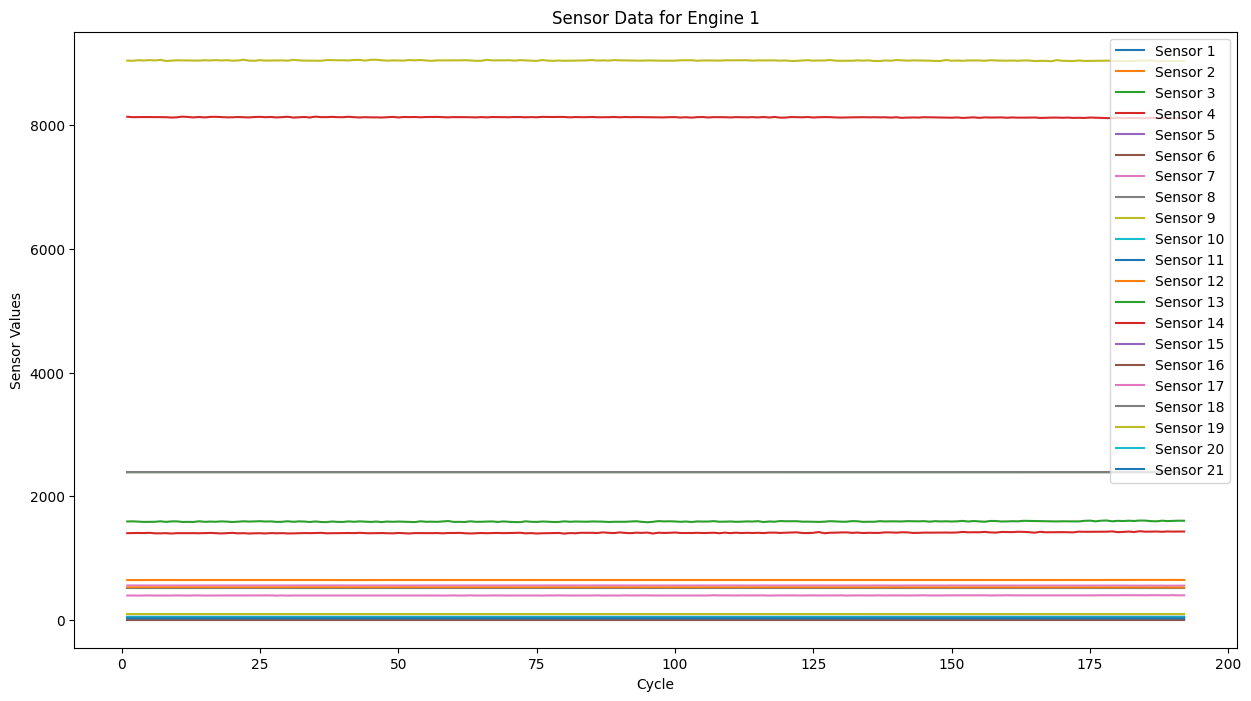

In [38]:
engine_1 = df[df['unit'] == 1]
plt.figure(figsize=(15, 8))
plt.plot(engine_1['cycle'], engine_1['sensor1'], label='Sensor 1')
plt.plot(engine_1['cycle'], engine_1['sensor2'], label='Sensor 2')
plt.plot(engine_1['cycle'], engine_1['sensor3'], label='Sensor 3')
plt.plot(engine_1['cycle'], engine_1['sensor4'], label='Sensor 4')
plt.plot(engine_1['cycle'], engine_1['sensor5'], label='Sensor 5')
plt.plot(engine_1['cycle'], engine_1['sensor6'], label='Sensor 6')
plt.plot(engine_1['cycle'], engine_1['sensor7'], label='Sensor 7')
plt.plot(engine_1['cycle'], engine_1['sensor8'], label='Sensor 8')
plt.plot(engine_1['cycle'], engine_1['sensor9'], label='Sensor 9')
plt.plot(engine_1['cycle'], engine_1['sensor10'], label='Sensor 10')
plt.plot(engine_1['cycle'], engine_1['sensor11'], label='Sensor 11')
plt.plot(engine_1['cycle'], engine_1['sensor12'], label='Sensor 12')
plt.plot(engine_1['cycle'], engine_1['sensor13'], label='Sensor 13')
plt.plot(engine_1['cycle'], engine_1['sensor14'], label='Sensor 14')
plt.plot(engine_1['cycle'], engine_1['sensor15'], label='Sensor 15')
plt.plot(engine_1['cycle'], engine_1['sensor16'], label='Sensor 16')
plt.plot(engine_1['cycle'], engine_1['sensor17'], label='Sensor 17')
plt.plot(engine_1['cycle'], engine_1['sensor18'], label='Sensor 18')
plt.plot(engine_1['cycle'], engine_1['sensor19'], label='Sensor 19')
plt.plot(engine_1['cycle'], engine_1['sensor20'], label='Sensor 20')
plt.plot(engine_1['cycle'], engine_1['sensor21'], label='Sensor 21')

plt.xlabel('Cycle')
plt.ylabel('Sensor Values')
plt.title('Sensor Data for Engine 1')
plt.legend()
plt.show()

### Correlation Heatmap

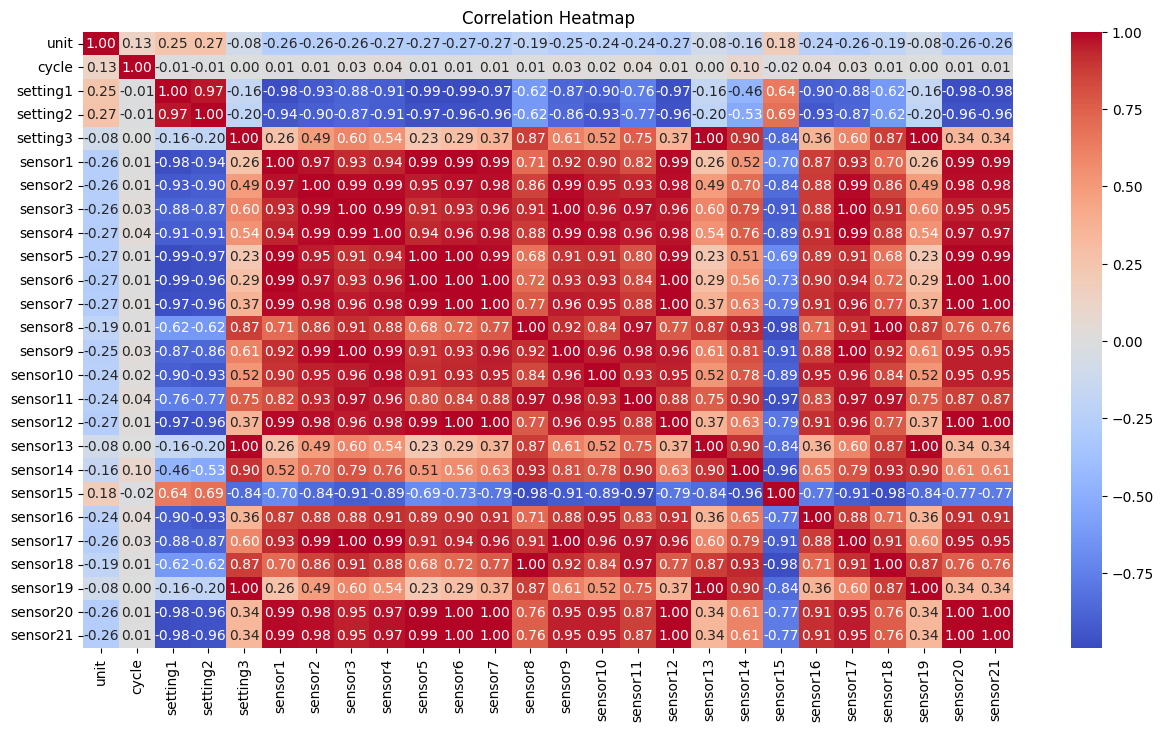

In [39]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Check for variances

In [40]:
variance = df.var()
print("Low Variance Sensors (std < 0.01):\n",variance[variance < 0.01])

Low Variance Sensors (std < 0.01):
 sensor16    0.000025
dtype: float64


The variance output confirms that little features have extremely low variance (std < 0.01), meaning they are nearly constant and unlikely to contribute meaningfully to predicting Remaining Useful Life (RUL) or maintenance needs

**NB**: This might be damaging, as the scale of the column itself also effects the size of std. It may have worked better for FD001?

## Data Cleaning

In [41]:
# drop_features = ['sensor16']
# df = df.drop(columns=drop_features)
# test_data = test_data.drop(columns=drop_features)

## Feature Engineering

In [42]:
df['RUL'] = df.groupby('unit')['cycle'].transform(lambda x: x.max() - x)
df['failure_30'] = (df['RUL'] <= 30).astype(int)

## Preprocessing

In [43]:
features = [col for col in df.columns if col not in ['unit', 'cycle', 'RUL', 'failure_30']]
X = df.drop(['RUL', 'failure_30'], axis=1)
y = df['RUL']

In [44]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X[features])
X_test_scaled = test_data.groupby('unit').tail(1)
X_test_scaled[features] = scaler.transform(X_test_scaled[features])
joblib.dump(scaler, '../artifacts/scaler.pkl')

['../artifacts/scaler.pkl']

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model Development

This is just a test block where I wanted to compare multiple models. 

In [46]:
import sys
import os

sys.path.append(os.path.abspath('../src'))
from custom_models import PointPredictor

models = {
    'RandomForest': RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1),
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1),
#     'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

best_RMSE = 100000000
best_model = None

results = []

if not isinstance(X_val, list):
    X_val = [X_val.iloc[[i]] for i in range(X_val.shape[0])]

for model_name, _model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()

    model = PointPredictor(_model, scaler=scaler)
    model.fit(X_train, preprocess=False)

    training_time = time.time() - start_time

    y_val_pred = model.predict(X_val, preprocess=False)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    y_test_pred = model.predict(X_test_scaled, preprocess=False)
    test_rmse = np.sqrt(mean_squared_error(rul_data['RUL'], y_test_pred))
    if test_rmse < best_RMSE:
        best_RMSE = test_rmse
        best_model = model

    results.append({
        'Model': model_name,
        'Training Time (s)': training_time,
        'Val RMSE': val_rmse,
        'Val MAE': val_mae,
        'Val R²': val_r2,
        'Test RMSE': test_rmse
    })

    print(f"{model_name} - Val RMSE: {val_rmse:.2f}, Test RMSE: {test_rmse:.2f}, Time: {training_time:.2f}s")

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

best_model_name = results_df.loc[results_df['Test RMSE'].idxmin(), 'Model']
print(f"\nBest Model: {best_model_name} with Test RMSE: {results_df['Test RMSE'].min():.2f}")


Training RandomForest...


TypeError: PointPredictor.fit() got an unexpected keyword argument 'preprocess'

In [ ]:
joblib.dump(best_model, '../artifacts/model.joblib')

In [ ]:
y_test_pred = best_model.predict(X_test_scaled, preprocess=False)
print("Test RMSE:", np.sqrt(mean_squared_error(rul_data['RUL'], y_test_pred)))